# Analyze Energy Ratios with Wake Steering

In this notebook, we will compare energy ratios computed using data from baseline and wake steering control periods. The energy ratios for the two control cases will be compared to evaluate the impact of wake steering on the energy production of the test turbines.

In [1]:

from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from flasc.visualization import plot_binned_mean_and_ci

from flasc.energy_ratio import energy_ratio_suite

# Polars stuff
from flasc.energy_ratio_polars import energy_ratio_polars as erp
import polars as pl

from models import load_smarteole_floris

import copy

In [2]:
# Suppress warnings
import warnings

warnings.filterwarnings('ignore')

# Parameters

In [3]:
N_boostrap = 20 # Number to use in bootstrapping
num_blocks = 20 # Number of blocks in block boostrapping

# Step 0: Load processed data

Load the processed SCADA data with power curve filtering and northing calibration applied and inspect

In [4]:
def load_data():
    root_path = Path.cwd()
    f = root_path / "postprocessed" / "df_scada_data_60s_filtered_and_northing_calibrated.ftr"
    df_scada = pd.read_feather(f)

    # # Optionally: downsample to [x] minute averages to speed up things
    # cols_angular = [c for c in df_scada if (("wd_" in c) or ("yaw_" in c))]
    # df_scada = fto.df_downsample(
    #     df_scada,
    #     cols_angular=cols_angular,
    #     window_width=td(seconds=600),
    # )

    return df_scada

df_scada_pandas = load_data()

In [5]:
df_scada_pandas.head()

,time,pow_000,pow_001,pow_002,pow_003,pow_004,pow_005,pow_006,ws_000,ws_001,...,is_operation_normal_005,is_operation_normal_006,wind_vane_005,target_yaw_offset_005,control_mode,wd_smarteole,ws_smarteole,pow_ref_smarteole,ti,wd
0,2020-02-17 16:30:00,2023.746948,2045.376953,2031.724976,NaN,2028.063965,2032.461060,1983.390991,13.066,12.337,...,True,True,3.299,-0.0,baseline,251.041672,12.582482,2021.060059,0.11,251.377068
1,2020-02-17 16:31:00,1959.036011,2050.572998,2034.890991,NaN,2017.777954,1943.764038,2046.568970,12.091,13.057,...,True,True,1.825,-0.0,baseline,251.282684,12.823891,2022.767212,0.11,251.485048
2,2020-02-17 16:32:00,2053.658936,2032.191040,2011.870972,NaN,NaN,2052.092041,2039.948975,13.381,12.213,...,True,True,8.314,-0.0,baseline,252.874130,12.859400,2034.417480,0.11,253.473037
3,2020-02-17 16:33:00,2044.296997,2060.478027,1995.057983,NaN,NaN,2008.868042,2058.000000,14.345,13.141,...,True,True,2.384,-0.0,baseline,251.341553,13.426766,2039.458252,0.11,251.104001
4,2020-02-17 16:34:00,2058.281006,2042.703003,2031.723999,NaN,NaN,1819.896973,2059.760010,14.338,12.723,...,True,True,17.271,-0.0,baseline,253.343018,13.225105,2048.116943,0.11,255.679234


# Step 0: Reminder on layout

Text(0.5, 1.0, 'Plot with turbine names')

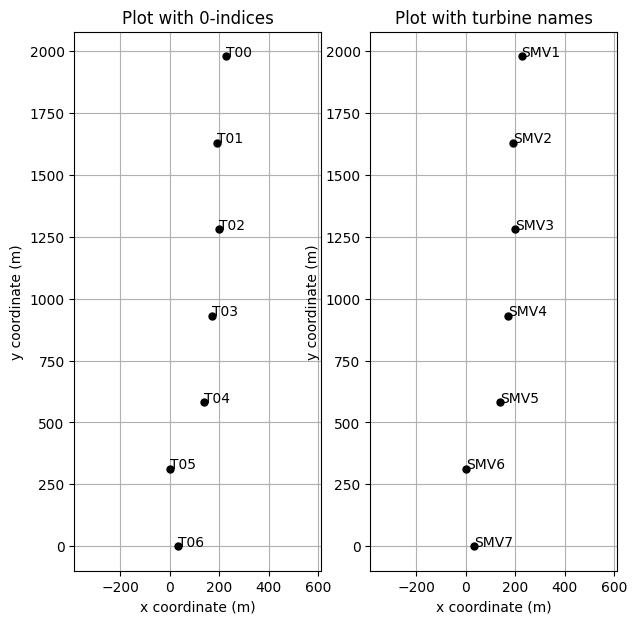

In [6]:
from flasc.visualization import  plot_layout_only
fi = load_smarteole_floris(wake_model="gch", wd_std=0.0)
turbine_names = ["SMV{:d}".format(i) for i in range(1, 8)]
## Show the basic layout
fig, axarr = plt.subplots(1,2,figsize=(7, 7))

ax = axarr[0]
plot_layout_only(fi,ax=ax)
ax.set_title('Plot with 0-indices')

ax = axarr[1]
plot_layout_only(fi,{'turbine_names':turbine_names},ax=ax)
ax.set_title('Plot with turbine names')


# Step 0b: Identify reference turbines using 0-indices

In [7]:
    # df["wd_smarteole"] = circ.calc_wd_mean_radial(df[["wd_{:03d}".format(ii) for ii in [0, 1, 2, 6]]],axis=1)
    # df["ws_smarteole"] = df[["ws_{:03d}".format(ii) for ii in [0, 1, 2, 6]]].mean(axis=1)
    # df["pow_ref_smarteole"] = df[["pow_{:03d}".format(ii) for ii in [0, 1, 2, 6]]].mean(axis=1)

# Step 2: Prepare the data for computing energy ratios

The energy ratio class as presently implemented requires explicit identification of the dataframe of the reference wind direction, wind speed, and power columns: "wd," "ws," and "pow_ref." Here, we will set these equal to the reference variables used in the SMARTEOLE wake steering experiment, which we computed in "02_download_and_format_dataset.ipynb".

In [8]:
# Assign wd, ws and pow ref
# Subset dataframe
df_scada_pandas = (df_scada_pandas
    .assign(
        wd = lambda df_: df_['wd_smarteole'],
        ws = lambda df_: df_['ws_smarteole'],
        pow_ref = lambda df_: df_['pow_ref_smarteole']
    )
)

In [9]:
# Split df_scada into baseline and wake steeering on "controlled"
# periods
df_base_pandas = df_scada_pandas[df_scada_pandas.control_mode=='baseline']
df_con_pandas = df_scada_pandas[df_scada_pandas.control_mode=='controlled']

In [10]:
# Construct energy ratio object
s = energy_ratio_suite.energy_ratio_suite()
s.add_df(df_base_pandas, name="Baseline", color='k') # Just add baseline for now
# s.add_df(df_con_pandas, name="Controlled", color='r')


# Step 2b: Equivalent steps in polars

In [11]:
df_scada_polars = pl.from_pandas(df_scada_pandas)
df_scada_polars.head()

# Polars methods doesn't currently use a special ws/wd/pow_ref column so for now 
# let's just apply the precomuted values back to to turbine 0
df_scada_polars = (df_scada_polars
   .with_columns(
        pow_000 = pl.col('pow_ref_smarteole'),
        wd_000 = pl.col('wd_smarteole'),
        ws_000 = pl.col('ws_smarteole')
    
        )
)

df_base_polars = df_scada_polars.filter(pl.col('control_mode')=='baseline')
df_con_polars = df_scada_polars.filter(pl.col('control_mode')=='controlled')

# Just baseline for now
df_energy_no_blocks = erp.get_energy_table([df_base_polars], ['baseline'],num_blocks=df_base_polars.shape[0])
df_energy_with_blocks = erp.get_energy_table([df_base_polars], ['baseline'],num_blocks= num_blocks)

# Step 3 Compare Energy Ratio of T4 / ref without bootstrapping

In [12]:
# Pandas energy ratio calc
s.get_energy_ratios(
            test_turbines=[4],
            ws_step=1.0,
            wd_bin_width=2.0,
            wd_step=2.0
        )
print('finished')

Dataframes differ in wd and ws. Rebalancing.
Calculating energy ratios with N = 1.
finished


In [13]:
df_erb = erp.compute_energy_ratio(df_energy_no_blocks,
                                            ref_turbines=[0],
                                            test_turbines=[4],
                                            df_names = ['baseline'],
                                            ws_turbines =  [0],
                                            wd_turbines = [0])

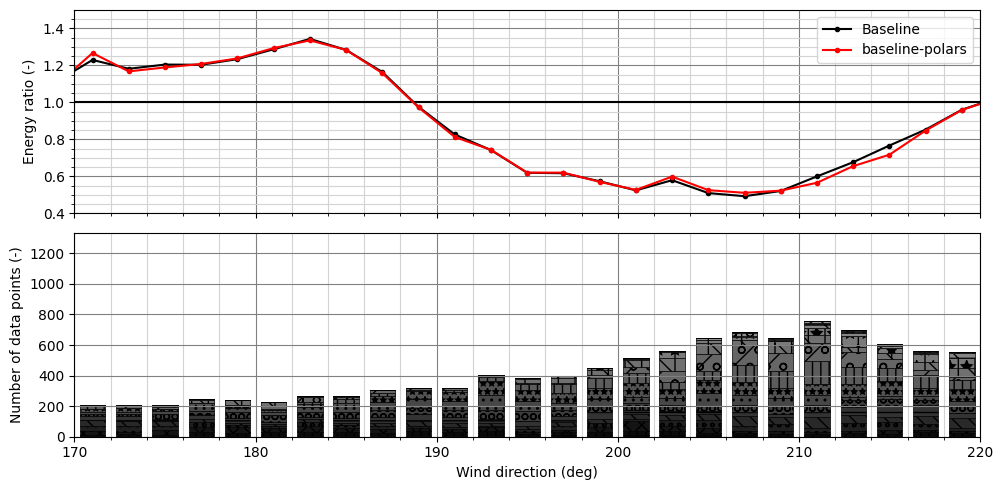

In [14]:
fig, axarr = plt.subplots(2,1,sharex=True,figsize=(10,5))
s.plot_energy_ratios(show_barplot_legend=False, axarr=axarr)

axarr[0].plot(df_erb['wd_bin'], df_erb['baseline'],'.-', color='r',label='baseline-polars')


axarr[0].set_xlim([170,220])
axarr[0].set_ylim([0.4,1.5])
axarr[0].legend()

# Step 4: Recompute with normal bootstrapping

In [15]:
# Pandas energy ratio calc
s.get_energy_ratios(
            test_turbines=[4],
            ws_step=1.0,
            wd_bin_width=2.0,
            wd_step=2.0,
            N=N_boostrap
        )
print('finished')

Dataframes differ in wd and ws. Rebalancing.
Calculating energy ratios with N = 20.
finished


In [16]:
# Polars energy ratio calc
df_erb = erp.compute_energy_ratio_bootstrap(df_energy_no_blocks,
                                            ref_turbines=[0],
                                            test_turbines=[4],
                                            df_names = ['baseline'],
                                            ws_turbines =  [0],
                                            wd_turbines = [0],
                                            N = N_boostrap)
print('finished')        

finished


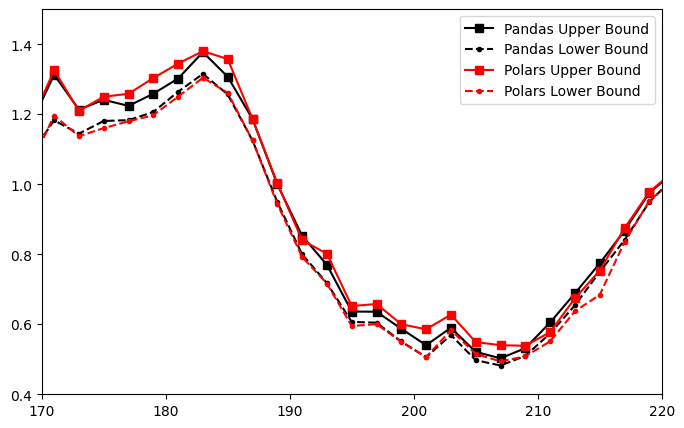

In [36]:
# Plot comparing the boostrap locations
pandas_result = s.df_list[0]["er_results"]

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(pandas_result.wd_bin, pandas_result.baseline_ub,'ks-',label='Pandas Upper Bound')
ax.plot(pandas_result.wd_bin, pandas_result.baseline_lb,'k.--',label='Pandas Lower Bound')

ax.plot(df_erb['wd_bin'], df_erb['baseline_ub'],'rs-',label='Polars Upper Bound')
ax.plot(df_erb['wd_bin'], df_erb['baseline_lb'],'r.--',label='Polars Lower Bound')

ax.set_xlim([170,220])
ax.set_ylim([0.4,1.5])
ax.legend()


# Step 5: Compare with block bootstrapping

In [37]:
# Pandas energy ratio calc
s.get_energy_ratios(
            test_turbines=[4],
            ws_step=1.0,
            wd_bin_width=2.0,
            wd_step=2.0,
            num_blocks=num_blocks,
            N=N_boostrap
        )
print('finished')

Dataframes differ in wd and ws. Rebalancing.
Calculating energy ratios with N = 20.
finished


In [38]:
# Polars energy ratio calc
df_erb = erp.compute_energy_ratio_bootstrap(df_energy_with_blocks,
                                            ref_turbines=[0],
                                            test_turbines=[4],
                                            df_names = ['baseline'],
                                            ws_turbines =  [0],
                                            wd_turbines = [0],
                                            N = N_boostrap)
print('finished')    

finished


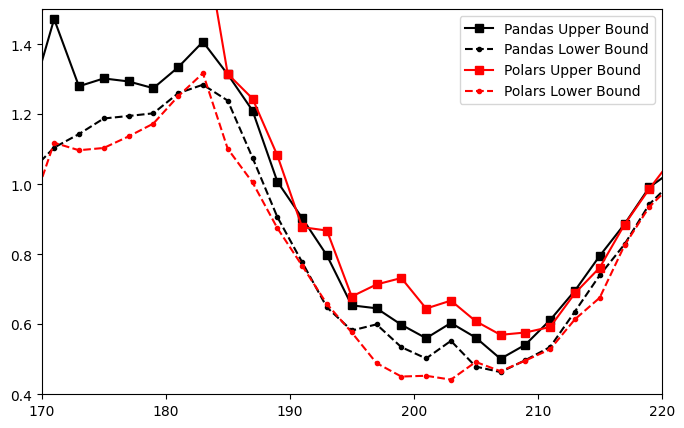

In [40]:
# Plot comparing the boostrap locations
pandas_result = s.df_list[0]["er_results"]

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(pandas_result.wd_bin, pandas_result.baseline_ub,'ks-',label='Pandas Upper Bound')
ax.plot(pandas_result.wd_bin, pandas_result.baseline_lb,'k.--',label='Pandas Lower Bound')

ax.plot(df_erb['wd_bin'], df_erb['baseline_ub'],'rs-',label='Polars Upper Bound')
ax.plot(df_erb['wd_bin'], df_erb['baseline_lb'],'r.--',label='Polars Lower Bound')

ax.set_xlim([170,220])
ax.set_ylim([0.4,1.5])
ax.legend()

In [ ]:
# NOT READY THE CODE BELOW...

In [39]:
# fig, axarr = plt.subplots(2,1,sharex=True,figsize=(10,5))
# s.plot_energy_ratios(show_barplot_legend=False, axarr=axarr)

# axarr[0].plot(df_erb['wd_bin'], df_erb['baseline'],'.-', color='r',label='baseline-polars')
# axarr[0].plot(df_erb['wd_bin'], df_erb['baseline_ub'],'--', color='r',label='baseline-polars-upper')
# axarr[0].plot(df_erb['wd_bin'], df_erb['baseline_lb'],':', color='r',label='baseline-polars-lower')
# # ax.fill_between(df_erb['wd_bin'], df_erb['baseline_lb'], df_erb['baseline_ub'], color='k', alpha=0.2)

# axarr[0].set_xlim([170,220])
# axarr[0].set_ylim([0.4,1.5])
# axarr[0].legend()

